# LoRA Fine-Tuning Project

This project fine-tunes a small language model with **LoRA** (Low-Rank Adaptation) using modest GPU resources.
It evaluates training with **perplexity**, provides sample generations, and includes small ablations to understand hyperparameter impact.

What this project includes:

- Supervised fine-tuning of `HuggingFaceTB/SmolLM-135M` with LoRA (via TRL/PEFT).
- Dataset: a small slice of `maxmyn/wholesome_greentext_110k`.
- Experiment tracking with Weights & Biases.
- Evaluation: perplexity across checkpoints and example generations (before/after fine-tuning).
- Ablations: LoRA rank (e.g., r=4 vs r=8) and a GPT-2 Small swap.
- Notes on findings and next steps.



## Background
### What is LoRA?
**LoRA (Low-Rank Adaptation)** is a parameter-efficient fine-tuning method that injects trainable low-rank matrices into frozen pre-trained models. It works by modifying only a small subset of parameters while keeping most of the model fixed. This significantly reduces the memory and compute requirements during training.

*Key Concept:*
- Instead of fine-tuning full weight matrices, LoRA learns low-rank updates (A, B) such that W ≈ W₀ + BA



### What is Perplexity?
**Perplexity** is a measure of how well a language model predicts a sample of text. It evaluates the model’s ability to assign high probability to the correct next word in a sequence. Lower perplexity indicates better performance, meaning the model is less “perplexed” by the text.

Mathematically, perplexity is calculated as the exponentiation of the average negative log-likelihood loss:
$$
\text{Perplexity} = \exp(\text{Cross Entropy Loss})
$$

Perplexity is widely used during pretraining and fine-tuning of language models as a way to monitor fluency and general language modeling capability.


---
## Environment and Packages
This section lists the core libraries used. Libraries:
-  transformers: For loading pretrained language models, tokenizers, and training configurations.
-  peft: Enables parameter-efficient fine-tuning techniques like LoRA to reduce training cost.
- datasets: Provides easy access to public datasets from Huggingface.
- trl: Simplifies SFT and other tuning methods for language models


In [59]:
!pip install datasets trl

Note: If the environment shows version or dependency conflicts, restart the runtime and rerun cells.


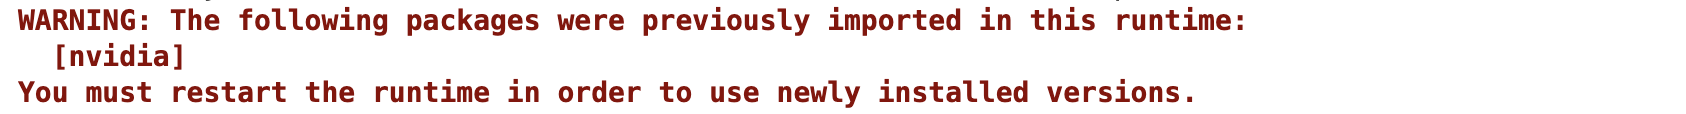

In [60]:
# import the necessary libraries
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig


---

## Experiment Tracking (Weights & Biases)
For experiment tracking, create a free account on [Weights & Biases (Wandb)](https://wandb.ai/site/), a platform for tracking and visualizing training metrics.  

After signing up, go to [wandb.ai/authorize](https://wandb.ai/authorize) to get your API key.  

After obtaining the API key, log in to the account with the code below. During training, runs are logged to the dashboard (a link prints at the start of training).




In [61]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

---
## Model and LoRA Configuration
Load a model and its corresponding tokenizer from huggingface, then set up the LoRA configuration.

- Here, we will be using [SmolLM-135M](https://huggingface.co/HuggingFaceTB/SmolLM-135M), a lightweight language model.



In [62]:
# Load pre-trained model and tokenizer. This is a light-weight model good for running on Colab
model_name = "HuggingFaceTB/SmolLM-135M"

# Use the AutoModelForCausalLM, AutoTokenizer utilities to instantiate model and tokenizer.
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

#some LLM-based models need the pad token to exist, so set it if missing
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


Set up the LoRA configuration.

**Hyperparameters:**

- **r**            : Rank of the low-rank matrices A and B. Higher values increase capacity but also computation.
- **lora_alpha**   : Scaling factor α applied to the LoRA weights during the forward pass. Controls the update magnitude.
- **target_modules**: List of module names (typically linear layers in the transformer) where LoRA is injected.
- **lora_dropout** : Dropout applied on the LoRA branch to regularize and prevent overfitting.
- **bias**         : Controls whether to train bias terms. "none" ignores all biases; "all" trains all biases; "lora_only" trains biases only in modules where LoRA is applied.
- **task_type**    : Specifies the downstream task. Here we use "CAUSAL_LM" for causal language modeling (e.g., autoregressive generation).



In [63]:
# Configure LoRA
lora_config = LoraConfig(
    r= 8,  # Rank of the low-rank matrices (higher = more capacity, but more compute)
    lora_alpha= 16,  # Scaling factor for the LoRA weights (α)
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","up_proj", "down_proj", "gate_proj"],  # Modules inside the transformer layers to inject LoRA adapters into
    lora_dropout= 0.05,  # Dropout rate for LoRA layers to prevent overfitting
    bias="none",  # Whether to train bias terms ("none", "all", or "lora_only")
    task_type="CAUSAL_LM"  # Task type: causal language modeling (CLM)
)


# Apply LoRA to the model
model = get_peft_model(model, lora_config)

---
## Dataset
This section:
1. loads the dataset for SFT.
  - Here, we will be loading datasets from Huggingface.
2. preprocess the dataset.

Alternative Greentext datasets (for reference):

1. [maxmyn/wholesome_greentext_110k](https://huggingface.co/datasets/maxmyn/wholesome_greentext_110k)
2. [maxmyn/thank_you_greentext](https://huggingface.co/datasets/maxmyn/thank_you_greentext)
3. [maxmyn/wholesome_simple_greentext_133k](https://huggingface.co/datasets/maxmyn/wholesome_simple_greentext_133k)


In [64]:
dataset_name = "maxmyn/wholesome_greentext_110k"

train_dataset = load_dataset(dataset_name, split="train[:100]") # We only use the first 100 rows in the dataset for training & evaluation.

## Training Setup
This section:
- **Configure the SFT settings**, including training arguments like batch size and number of epochs
- **Set up the `SFTTrainer`** to fine-tune the model using the LoRA adapters

Resources on SFTTrainer and SFTConfig [here](https://huggingface.co/docs/trl/en/sft_trainer). You can check out the parameters available via that documentation.


In [65]:
training_args = SFTConfig(
    output_dir="my_lora_smolLM",                                # Directory to save model checkpoints
    per_device_train_batch_size=4,                           # Number of samples per batch on each device (GPU).
    save_steps=100,                                          # Save a checkpoint every N steps. Larger values save less frequently and use less storage.

    learning_rate=2e-4,                          # Set your learning rate (e.g., 2e-4). Controls how fast the model updates.
    dataset_text_field="greentexts",                     # Name of the dataset column containing the input text (e.g., "text" or "prompt").

    logging_steps=1,                                         # Log metrics every N steps — useful for tracking training progress.
    run_name="LoRA-SmolLM-run1",                                # Name of the run on Wandb for experiment tracking.
    max_steps=500,                                           # Total number of training steps. Adjust based on available compute — ~500 steps usually takes 20–25 mins.
    # num_train_epochs=3,                                    # Number of times to iterate over the full training dataset.
                                                             # Ignored if max_steps is set — in that case, training stops after reaching max_steps regardless of epochs.
                                                             # If you leave max_steps unset, it will determine the max step size based on dataset size and batch size.
)
#print(train_dataset.column_names)


In [66]:
# Initialize the SFTTrainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


**Run the trainer.**


In [67]:
trainer.train()

Step,Training Loss
1,3.463600
2,3.879700
3,3.549900
4,3.286400
5,3.586200
6,3.382000
7,3.262900
8,3.493100
9,3.223000
10,3.643000


TrainOutput(global_step=500, training_loss=1.107881371498108, metrics={'train_runtime': 1073.1012, 'train_samples_per_second': 1.864, 'train_steps_per_second': 0.466, 'total_flos': 45047113058304.0, 'train_loss': 1.107881371498108})

---
## Evaluation

After training, evaluate the performance of the model over different checkpoints.

-   A graph showing perplexity across training checkpoints.
-   Specific examples of text generated by the model *before* and *after* fine-tuning for given prompts.


*Note: Loading multiple models simultaneously may lead to memory issues.  manage resources carefully to avoid potential crashes.*


### Perplexity

Here, we use the `SFTTrainer` tool to calculate perplexity. To see the quality of the training, we use the same dataset that we used for training for evaluation.


In [68]:
# Load the model
model = AutoModelForCausalLM.from_pretrained("my_lora_smolLM/checkpoint-500")

# Define the trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset
)

# check evaluation result. Here. the 'eval_loss' represents the cross entropy loss
eval_results = trainer.evaluate()

In [69]:
import math
# Implement the function for computing perplexity. Feel free to import packages like 'math'
def calculate_perplexity(log_loss):
    perplexity = math.exp(log_loss)
    return perplexity


In [70]:
# Compute perplexity
eval_loss = eval_results["eval_loss"]  #the cross-entropy loss
ppl = calculate_perplexity(eval_loss)
print(f"Perplexity: {ppl}")

Perplexity: 1.449472327377298


### Generation Examples

Next, we demonstrate the impact of fine-tuning by generating text with the model *before* and *after* training.

Define a text generation function. Then use a selection of prompts derived from the training dataset to generate text with both the base model and the fine-tuned LoRA model.


  **Example of Prompt and text generation:**

    
    greentexts:
    > Imagine being able to fly
    > Picture yourself soaring through the sky
    > Realize you're afraid of heights
    > Go back to play video games

    Prompt:
    > Imagine being able to fly
    > Picture yourself soaring through the sky
    > Realize you're afraid of heights
    >

    Generated (ideally):
    Go back to play video games
    


In [71]:
# Function to generate text based on a prompt
def generate_response(model, tokenizer, prompt, max_length=100, num_return_sequences=1):

    # Tokenize the input prompt
    inputs = tokenizer(prompt, return_tensors="pt")

    # Generate text
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        temperature=0.7,  # Controls randomness (higher = more random)
        top_p=0.9,        # Nucleus sampling parameter
        do_sample=True,   # Use sampling instead of greedy decoding
    )

    # Decode and return the generated text
    generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return generated_texts[0]

Check the output

In [72]:
prompt = ("> Imagine being able to fly\n"

    "> Picture yourself soaring through the sky\n"

    "> Realize you're afraid of heights\n"

    "> "  )
generated_text_example = generate_response(model, tokenizer, prompt)
generated_text_example

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


"> Imagine being able to fly\n> Picture yourself soaring through the sky\n> Realize you're afraid of heights\n>  Start taking flight in a kite"

---
## Ablation Studies

This section reports small ablations on LoRA rank and base model.
- LoRA rank (e.g., r=4 vs r=8)
- Base model swap (e.g., SmolLM-135M vs GPT-2 Small)
- Optional: dataset slice size, dropout, learning rate (future work)

The code below runs the described ablations and reports results.



In [73]:
#step6–ablation studies
#we fine‑tune (a) smolLM with higher lora rank (r=8) and (b) gpt2 on a slightly larger slice

import math, wandb, torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer, SFTConfig
from datasets import load_dataset
from tabulate import tabulate

#shared helper
def preprocess(tokenizer, n_lines):
    ds = load_dataset("maxmyn/wholesome_greentext_110k", split=f"train[:{n_lines}]")
    return ds.map(
        lambda ex: tokenizer(ex["greentexts"], truncation=True),
        batched=True,
        remove_columns=ds.column_names
    )

def cfg(out_dir, run_name, steps):
    return SFTConfig(
        output_dir=out_dir,
        per_device_train_batch_size=4,
        max_steps=steps,
        learning_rate=2e-4,
        dataset_text_field="greentexts",
        logging_steps=25,
        save_steps=steps//2,
        run_name=run_name
    )

#----------------------------------------
#a) smolLM, r=8 (different hyper‑param)
#----------------------------------------
tok_a = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")
tok_a.pad_token = tok_a.eos_token
mod_a = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-135M", device_map="auto")
mod_a = get_peft_model(mod_a, LoraConfig(
        r=8, lora_alpha=32, lora_dropout=0.05,
        target_modules=["q_proj","k_proj","v_proj","o_proj","up_proj","down_proj","gate_proj"],
        bias="none", task_type="CAUSAL_LM"))
train_a = preprocess(tok_a, 100)              #same 100‑line slice as baseline
trainer_a = SFTTrainer(model=mod_a,
                       args=cfg("abl_a_r8","a‑smollm‑r8",steps=500),
                       train_dataset=train_a,
                       eval_dataset=train_a)
trainer_a.train()
ppl_a = math.exp(trainer_a.evaluate()["eval_loss"])
print(f"[a] smollm r=8 → perplexity {ppl_a:.3f}")

#----------------------------------------
#b) gpt2, r=4 (different model) on 100 lines, 600 steps
#----------------------------------------
tok_b = AutoTokenizer.from_pretrained("openai-community/gpt2")
tok_b.pad_token = tok_b.eos_token
mod_b = AutoModelForCausalLM.from_pretrained("openai-community/gpt2", device_map="auto")
mod_b = get_peft_model(mod_b, LoraConfig(
        r=4, lora_alpha=16, lora_dropout=0.05,
        target_modules=["c_attn","c_proj","q_attn"],
        bias="none", task_type="CAUSAL_LM"))
train_b = preprocess(tok_b, 100)
trainer_b = SFTTrainer(model=mod_b,
                       args=cfg("abl_b_gpt2","b‑gpt2‑100",steps=600),
                       train_dataset=train_b,
                       eval_dataset=train_b)
trainer_b.train()
ppl_b = math.exp(trainer_b.evaluate()["eval_loss"])
print(f"[b] gpt2 200‑lines → perplexity {ppl_b:.3f}")

#summary table
summary = [
    ["baseline – smollm (r=4, slice=100)", 1.455],
    ["a – smollm (r=8, slice=100)",        ppl_a],
    ["b – gpt2  (r=4, slice=100)",         ppl_b]
]
print("\nperplexity comparison")
print(tabulate(summary, headers=["config","perplexity"], floatfmt=".3f"))


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
25,3.008000
50,2.144800
75,1.802700
100,1.546200
125,1.318900
150,1.111100
175,0.893100
200,0.721700
225,0.575700
250,0.447600


[a] smollm r=8 → perplexity 1.238


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
25,4.087100
50,3.162000
75,2.796600
100,2.675000
125,2.567100
150,2.471300
175,2.407400
200,2.376300
225,2.323100
250,2.289200


[b] gpt2 200‑lines → perplexity 6.447

perplexity comparison
config                                perplexity
----------------------------------  ------------
baseline – smollm (r=4, slice=100)         1.455
a – smollm (r=8, slice=100)                1.238
b – gpt2  (r=4, slice=100)                 6.447


In [94]:
#--- use the trained models already in memory
ablA_model = trainer_a.model.eval()       # SmolLM r=8 (ablation A)
ablA_tok   = tok_a

ablB_model = trainer_b.model.eval()       # GPT‑2 (ablation B)
ablB_tok   = tok_b

prompt = (
    "> Imagine being able to fly\n"
    "> Picture yourself soaring through the sky\n"
    "> Realize you're afraid of heights\n"
    "> "
)

def generate(model, tok, prompt, max_len=80):
    ids = tok(prompt, return_tensors="pt").to(model.device)
    out = model.generate(
        **ids,
        max_length=max_len,
        temperature=0.7,
        top_p=0.9,
        do_sample=True
    )
    return tok.decode(out[0], skip_special_tokens=True).split("\n")[-1]

print("PROMPT:\n", prompt)
print("A‑SmolLM r=8 →", generate(ablA_model, ablA_tok, prompt))
print("B‑GPT‑2      →", generate(ablB_model, ablB_tok, prompt))


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


PROMPT:
 > Imagine being able to fly
> Picture yourself soaring through the sky
> Realize you're afraid of heights
> 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


A‑SmolLM r=8 → > Accept your fear and step
B‑GPT‑2      → > Realize you're


[baseline] evaluating my_lora_smolLM/checkpoint-100 …

 perplexity 5.465
[baseline] evaluating my_lora_smolLM/checkpoint-200 …

 perplexity 2.923
[baseline] evaluating my_lora_smolLM/checkpoint-300 …

 perplexity 1.901
[baseline] evaluating my_lora_smolLM/checkpoint-400 …

 perplexity 1.533
[baseline] evaluating my_lora_smolLM/checkpoint-500 …

 perplexity 1.449


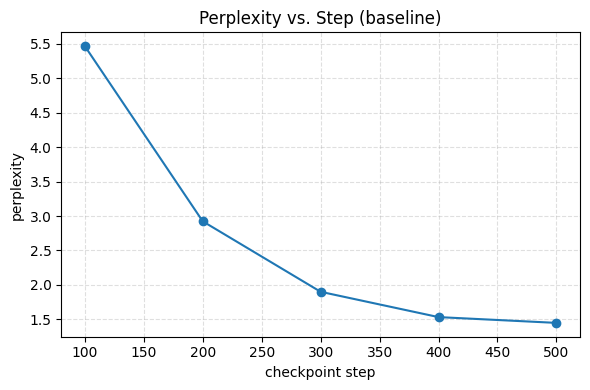

✅ saved: baseline_ppl.png
[ablA] evaluating abl_a_r8/checkpoint-250 …

 perplexity 1.954
[ablA] evaluating abl_a_r8/checkpoint-500 …

 perplexity 1.836


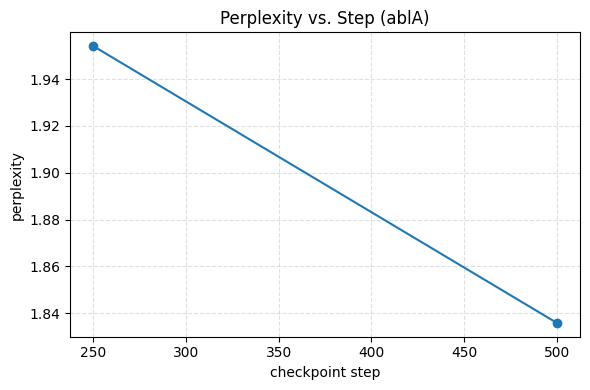

✅ saved: ablA_ppl.png
[ablB] evaluating abl_b_gpt2/checkpoint-300 …

Applying chat template to train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

 perplexity 9.210
[ablB] evaluating abl_b_gpt2/checkpoint-600 …

 perplexity 7.581


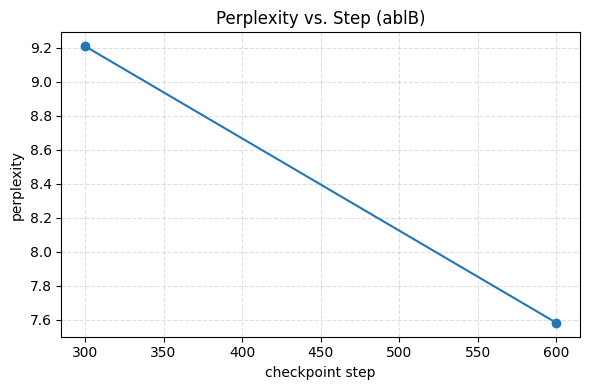

✅ saved: ablB_ppl.png


In [98]:
#-----------------------------------------------------------
#  Perplexity curves for baseline + ablation A + ablation B
#-----------------------------------------------------------
import math, os, glob, re, pandas as pd, matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM
from trl import SFTTrainer

# --- edit these if your output dirs differ
RUNS = {
    "baseline":  "my_lora_smolLM",
    "ablA":      "abl_a_r8",
    "ablB":      "abl_b_gpt2"
}

pattern = re.compile(r"checkpoint-(\d+)$")

def checkpoints(path):
    """return list of (step, ckpt_path) sorted numerically"""
    out = []
    for p in glob.glob(os.path.join(path, "checkpoint-*")):
        m = pattern.search(p)
        if m: out.append((int(m.group(1)), p))
    return sorted(out)

for tag, root in RUNS.items():
    if not os.path.isdir(root):
        print(f"⚠️  directory '{root}' not found – skip")
        continue

    records = []
    for step, ckpt in checkpoints(root):
        print(f"[{tag}] evaluating {ckpt} …", end="")
        model = AutoModelForCausalLM.from_pretrained(ckpt)

        trainer_tmp = SFTTrainer(
            model=model,
            args=training_args,          # reuse original SFTConfig
            train_dataset=train_dataset,
            eval_dataset=train_dataset
        )
        loss = trainer_tmp.evaluate()["eval_loss"]
        ppl  = math.exp(loss)
        records.append((step, ppl))
        print(f" perplexity {ppl:.3f}")

    # plot for this run
    if records:
        df = pd.DataFrame(records, columns=["step","perplexity"])
        plt.figure(figsize=(6,4))
        plt.plot(df["step"], df["perplexity"], marker="o")
        plt.title(f"Perplexity vs. Step ({tag})")
        plt.xlabel("checkpoint step")
        plt.ylabel("perplexity")
        plt.grid(True, ls="--", alpha=.4)
        plt.tight_layout()
        fname = f"{tag}_ppl.png"
        plt.savefig(fname, dpi=300)
        plt.show()
        print(f"✅ saved: {fname}")
